# Average inflow planes

In [1]:
# Load the amrwind-frontend module
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['../',
                 '../../',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Important header information                                                                                                                                               
import postprolib as pp
# Load the libraries                                                                                                                                                         
import postproamrwindsample as ppsample
import numpy             as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import postproamrwindsample_xarray as ppsamplexr
import pickle
import pandas as pd

import classifyKPturbines

# Make all plots inline 
%matplotlib inline

In [2]:
def makecbarax(ax, c, fontsize, size='5%'):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=0.05)
    cbar=fig.colorbar(c, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=fontsize)

def getTurbSubset(csvfile, suffix):
    # Load the data from the database of all turbines
    allturbsdf = pd.read_csv(csvfile, low_memory=False)
    # Get just the King Plains turbines
    subset = [] 
    for x in allturbsdf.iterrows():
        if x[1]['# name'].endswith(suffix):
            subset.append(x[1])
    subsetdf = pd.DataFrame(subset[:])
    return subsetdf

def getRotorDisk(xbase, ybase, zhh, rotorD, numpoints=36):
    ptlist=[]
    dtheta = 2*np.pi/numpoints
    for ipt in np.arange(numpoints):
        x = xbase + 0.5*rotorD*np.cos(dtheta*ipt)
        y = ybase 
        z = zhh   + 0.5*rotorD*np.sin(dtheta*ipt)
        ptlist.append([x,y,z])
    ptlist.append(ptlist[0])
    return np.array(ptlist)
    
def plotturbs(turbdf, turblist, zhh, D, ax, plotdisk=True):
    for x in turbdf.iterrows(): 
        name = x[1]['# name']
        xturb, yturb = float(x[1][' x']), float(x[1][' y'])
        if name in turblist:
            ax.plot(xturb, zhh, 'o',color='k', markersize=1)
            if plotdisk:
                rotorpts = getRotorDisk(xturb, yturb, zhh, D)
                ax.plot(rotorpts[:,0], rotorpts[:,2], 'k-', linewidth=0.25)
    return

In [3]:
summitcsv    = '../../UnstableABL_farmrun_turbines.csv'

iplane       = 0
zhh          = 90
rotorD       = 127

In [4]:
savefigs = True
figdir   = '../JRSE_figs'

In [5]:
KPturbdf = getTurbSubset(summitcsv, '-KP')

In [6]:
# Run through and average
rundir       = '/lustre/orion/cfd162/scratch/lcheung/AWAKEN/UnstableABL1_farmrun2_wturbs/post_processing/'
ncfile       = 'KP_inflow1_64500.nc'
timerange    = [16125+300, 16125+960]
extrafuncs   = {}
pklfile      = 'AllKP_inflowplanes_wturb.pkl'
groupname    = 'Farm_KP_ioflow1'

In [7]:
ds_wturbs = ppsamplexr.MinMaxStd_PlaneXR(rundir+'/'+ncfile, timerange, groupname=groupname, extrafuncs=extrafuncs,
                                         verbose=True, includeattr=True)

Calculating averages
[============================================================] 100.0% 
Calculating min/max/std
[============================================================] 100.0% 


In [8]:
# Run through and average
rundir       = '/lustre/orion/cfd162/scratch/lcheung/AWAKEN/UnstableABL1_farmrun2_noturbs/post_processing/'
ds_noturbs = ppsamplexr.MinMaxStd_PlaneXR(rundir+'/'+ncfile, timerange, groupname=groupname, extrafuncs=extrafuncs,
                                         verbose=True, includeattr=True)

Calculating averages
[============================================================] 100.0% 
Calculating min/max/std
[============================================================] 100.0% 


In [9]:
ds_wturbs.keys()

dict_keys(['times', 'group', 'x', 'y', 'z', 'velocityx_avg', 'velocityy_avg', 'velocityz_avg', 'sampling_type', 'ijk_dims', 'origin', 'axis1', 'axis2', 'axis3', 'offsets', 'velocityx_std', 'velocityx_max', 'velocityx_min', 'velocityy_std', 'velocityy_max', 'velocityy_min', 'velocityz_std', 'velocityz_max', 'velocityz_min'])

In [10]:
xm = ds_wturbs['x'][0,:,:]
ym = ds_wturbs['y'][0,:,:]
zm = ds_wturbs['z'][0,:,:]

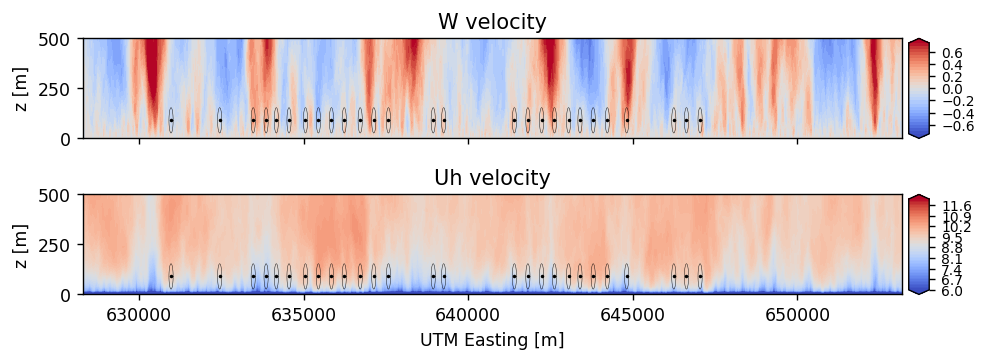

In [11]:
wlevels = np.linspace(-0.75,0.75,31)
vlevels = np.linspace(6,12,61)
fontsize= 8

iplane  = 0
turbrow = classifyKPturbines.turbinecategorylist['frontrow'] + classifyKPturbines.turbinecategorylist['AFwaked']
ds      = ds_noturbs 

Uh = np.sqrt(ds['velocityx_avg'][iplane,:,:]**2 + ds['velocityy_avg'][iplane,:,:]**2)

fig, axs = plt.subplots(2,1, figsize=(8,3), dpi=125, sharex=True)
# W plot
c = axs[0].contourf(xm, zm, ds['velocityz_avg'][iplane,:,:], levels=wlevels, extend='both', cmap='coolwarm')
makecbarax(axs[0], c, fontsize, size='2.5%')
plotturbs(KPturbdf, turbrow, zhh, rotorD, axs[0])
axs[0].set_title('W velocity')
# Uh plot
c = axs[1].contourf(xm, zm, Uh, levels=vlevels, extend='both', cmap='coolwarm')
makecbarax(axs[1], c, fontsize, size='2.5%')
plotturbs(KPturbdf, turbrow, zhh, rotorD, axs[1])
axs[1].set_title('Uh velocity')
axs[1].set_xlabel('UTM Easting [m]')
fig.subplots_adjust(hspace=0.4)
for ax in axs:
    ax.set_ylabel('z [m]')
#axs[1].set_xlim([641000, 648000])

plt.tight_layout()
if savefigs:
    plt.savefig(figdir+'/inflowplane_i0_full.png')
    plt.savefig(figdir+'/inflowplane_i0_full.pdf')

(641000.0, 647500.0)

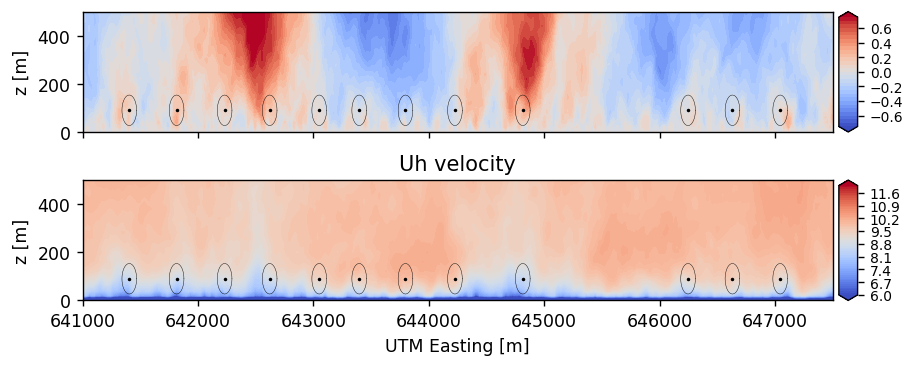

In [12]:
fig, axs = plt.subplots(2,1, figsize=(8,3), dpi=125, sharex=True)
# W plot
c = axs[0].contourf(xm, zm, ds['velocityz_avg'][iplane,:,:], levels=wlevels, extend='both', cmap='coolwarm')
makecbarax(axs[0], c, fontsize, size='2.5%')
plotturbs(KPturbdf, turbrow, zhh, rotorD, axs[0])
# Uh plot
c = axs[1].contourf(xm, zm, Uh, levels=vlevels, extend='both', cmap='coolwarm')
makecbarax(axs[1], c, fontsize, size='2.5%')
plotturbs(KPturbdf, turbrow, zhh, rotorD, axs[1])
fig.subplots_adjust(hspace=0.4)
axs[1].set_title('Uh velocity')
axs[1].set_xlabel('UTM Easting [m]')
for ax in axs:
    ax.set_ylabel('z [m]')
axs[1].set_xlim([641000, 647500])
#axs[1].set_ylim([0,600])

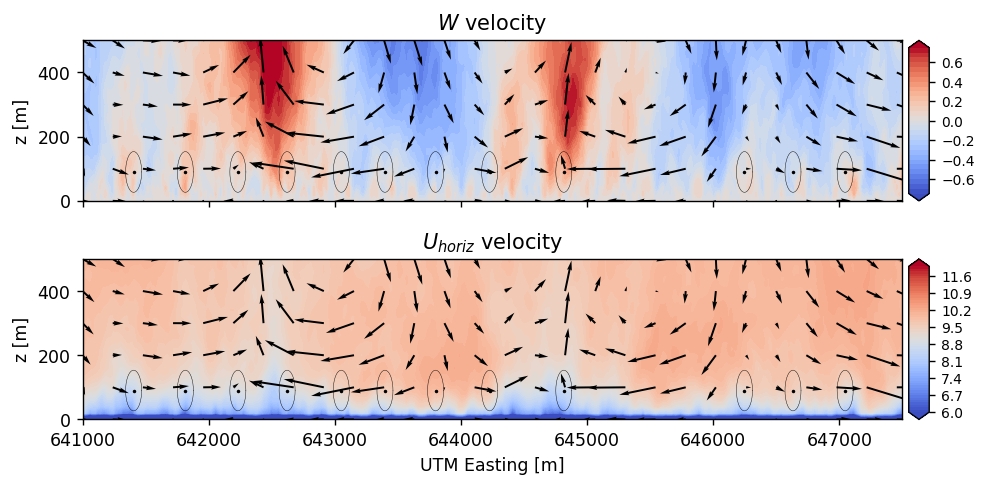

In [13]:
# Set up the quiver arrows
iplane=0
s1=5
s2=12
theta=5
nx, ny = np.cos(theta*np.pi/180.0), np.sin(theta*np.pi/180.0)

qx = xm[::s1,::s2]
qz = zm[::s1,::s2]
qu = ds['velocityx_avg'][iplane,::s1,::s2]
qv = ds['velocityy_avg'][iplane,::s1,::s2]
qw = ds['velocityz_avg'][iplane,::s1,::s2]
qprime = qu*nx + qv*ny
quplot = qprime #qu - np.mean(qu)

fig, axs = plt.subplots(2,1, figsize=(8,4), dpi=125, sharex=True)
ax=axs[0]

# W plot
c = ax.contourf(xm, zm, ds['velocityz_avg'][iplane,:,:], levels=wlevels, extend='both', cmap='coolwarm')
ax.quiver(qx, qz, quplot, qw, headwidth=2.5)
makecbarax(ax, c, fontsize, size='2.5%')
plotturbs(KPturbdf, turbrow, zhh, rotorD, ax)
axs[0].set_title('$W$ velocity')

ax = axs[1]
c = ax.contourf(xm, zm, Uh, levels=vlevels, extend='both', cmap='coolwarm')
ax.quiver(qx, qz, quplot, qw, headwidth=2.5)
makecbarax(ax, c, fontsize, size='2.5%')
plotturbs(KPturbdf, turbrow, zhh, rotorD, ax)
axs[1].set_title('$U_{horiz}$ velocity')
axs[1].set_xlabel('UTM Easting [m]')
for ax in axs:
    ax.set_ylabel('z [m]')
ax.set_xlim([641000, 647500])
plt.tight_layout()

if savefigs:
    plt.savefig(figdir+'/inflowplane_i0_zoom.png')
    plt.savefig(figdir+'/inflowplane_i0_zoom.pdf')